# Sistema de recomendación de juegos de mesa  
## Procesamiento del lenguaje natural

## Objetivo

Buscamos por medio de los datos sobre juegos de mesa de la pagina **BGG**, sugerir o recomendar juegos que se parezcan por su descripción a un juego que le haya agrado al usuario, con el fin de acotar la busqueda de posibles juegos de mesa y darle una mejor experiencia de usuario a la hora de incursionar en nuevos juegos

## Conocimientos aplicados 

Entre varios conceptos del procesamiento del lenguaje natural, fueron necesario el entendimiento de los siguientes conceptos:  
- Stopwords 
- Stemer
- Doc-Term matrix

Algunas métricas como lo son:  
- Euclidiana
- Coseno

Y una tecnica de reducción de dimensionalidad llamada:  
- Latent Dirichlet Allocation (LDA)

# Modules

In [1]:
## Data manipulation
import numpy as np
import pandas as pd

## Procesamiento del texto
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

## Text to vect
from sklearn.feature_extraction.text import TfidfVectorizer

## Distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


## Graphs
import plotly.express as px



# Relevant functions

In [2]:
def get_description(df,position):
    game_id=df["GameId"][position]
    index_game=int(df[df["GameId"]==game_id].index[0])
    name=df["GameName"][index_game]
    description= df["Description"][index_game]
    return name, game_id, description

In [3]:
def searchGame(df,game):
    return df[df["GameName"]==game].index[0]

In [4]:
def get_top_games(distances,similaritiesTfi,gamePosition):
    ls_dis= [10,10,10,10,10]
    for distance in distances[gamePosition]:
        maxi=  max(ls_dis)
        if(distance<maxi):
            position= ls_dis.index(maxi)
            ls_dis[position]= distance
    ls_dis.sort()
    ls_distances= list(distances[gamePosition])
    ls_euclidean=[]
    for value in ls_dis:
        ls_euclidean.append(ls_distances.index(value))
    ls_sim= [0,0,0,0,0]
    for similarity in similaritiesTfi[gamePosition]:
        mini= min(ls_sim)
        if(similarity> mini):
            position= ls_sim.index(mini)
            ls_sim[position]= similarity
    ls_sim.sort(reverse=True)
    ls_similarities= list(similaritiesTfi[gamePosition])
    ls_cosine= []
    for value in ls_sim:
        ls_cosine.append(ls_similarities.index(value))
    return ls_euclidean,ls_cosine

In [5]:
def get_top_words(term_document_matrix_tfi,gameId):   
    top_words=term_document_matrix_tfi.sort_values(by=str(gameId), ascending=False).head(5)[str(gameId)]
    print("--------------Top 5 important words-------------")
    for word,importance in top_words.items():
        print(f"\t{word}")

In [6]:
def show_similar(df_boardgames,term_document_matrix_tfi,ls_cosine,ls_euclidean,full,initial):
    name,game_id,description= get_description(df_boardgames, initial)
    print(f"El juego que te gusto es: {name} ")
    print(f'GameId; {game_id}')
    print(f'Description: {description}')
    print("Los juegos que son similares por descripción son:")
    print("--------------------Angles-----------------------")
    for number,game in enumerate(ls_cosine):
        print(f"Top {number+1} cosine metric") 
        print("-----------------------------")
        name,game_id,description= get_description(df_boardgames, game)
        print(f'Name: {name}')
        print(f'GameId; {game_id}')
        if(full):
            print(f'Description: {description}') 
        get_top_words(term_document_matrix_tfi, game_id)
    print("-----------------Distances-------------------")
    for number,game in enumerate(ls_euclidean):
        print(f"Top {number+1} euclidean metric") 
        print("-----------------------------")
        name,game_id,description= get_description(df_boardgames, game)
        print(f'Name: {name}')
        print(f'GameId; {game_id}')
        if(full):
            print(f'Description: {description}') 
        get_top_words(term_document_matrix_tfi, game_id)

# Data

## Boardgames description data

In [2]:
data_games=pd.read_csv("games.csv")

In [3]:
data_games.head()

,GameId,GameName,Description
0,148494,"1,2,3! Now you see me...",The animals on the farm are playing a game of ...
1,316377,7 Wonders (Second Edition),7 Wonders<br/>The board game with more awards ...
2,155987,Abyss,"The Abyss power is once again vacant, so the t..."
3,21569,Adigma,Adigma is a party game which involves simultan...
4,31260,Agricola,Description from BoardgameNews<br/><br/>In Agr...


# Preprocessing

## Boardgames

In [4]:
prepro_boardgames= data_games.copy()

### Missings

In [5]:
prepro_boardgames.isna().mean()

GameId         0.0
GameName       0.0
Description    0.0
dtype: float64

### Text

#### Drop HTML tags

In [6]:
prepro_boardgames["Description"]=prepro_boardgames["Description"].map(lambda x: x.replace("<br/>", " "))
prepro_boardgames["Description"]=prepro_boardgames["Description"].map(lambda x: x.replace("&quot;", " "))
prepro_boardgames["Description"]=prepro_boardgames["Description"].map(lambda x: x.replace("|", " "))

In [7]:
data_games["Description"][4]

"Description from BoardgameNews<br/><br/>In Agricola, you're a farmer in a wooden shack with your spouse and little else. On a turn, you get to take only two actions, one for you and one for the spouse, from all the possibilities you'll find on a farm: collecting clay, wood, or stone; building fences; and so on. You might think about having kids in order to get more work accomplished, but first you need to expand your house. And what are you going to feed all the little rugrats?<br/><br/>The game supports many levels of complexity, mainly through the use (or non-use) of two of its main types of cards, Minor Improvements and Occupations. In the beginner's version (called the Family Variant in the U.S. release), these cards are not used at all. For advanced play, the U.S. release includes three levels of both types of cards; Basic (E-deck), Interactive (I-deck), and Complex (K-deck), and the rulebook encourages players to experiment with the various decks and mixtures thereof. Aftermarke

In [8]:
prepro_boardgames["Description"][4]

"Description from BoardgameNews  In Agricola, you're a farmer in a wooden shack with your spouse and little else. On a turn, you get to take only two actions, one for you and one for the spouse, from all the possibilities you'll find on a farm: collecting clay, wood, or stone; building fences; and so on. You might think about having kids in order to get more work accomplished, but first you need to expand your house. And what are you going to feed all the little rugrats?  The game supports many levels of complexity, mainly through the use (or non-use) of two of its main types of cards, Minor Improvements and Occupations. In the beginner's version (called the Family Variant in the U.S. release), these cards are not used at all. For advanced play, the U.S. release includes three levels of both types of cards; Basic (E-deck), Interactive (I-deck), and Complex (K-deck), and the rulebook encourages players to experiment with the various decks and mixtures thereof. Aftermarket decks such as 

#### Punctuation characters

In [9]:
sep = '|'
punctuation_chars = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'

In [10]:
mapping_table = str.maketrans(dict.fromkeys(punctuation_chars, ''))

In [11]:
text_features = ['Description']

In [12]:
for column in text_features:
    prepro_boardgames[column] = sep \
    .join(prepro_boardgames[column].tolist()) \
    .translate(mapping_table) \
    .split(sep)

#### Lower cases

In [13]:
prepro_boardgames["Description"]=prepro_boardgames["Description"].map(lambda x: x.lower())
prepro_boardgames["Description"]=prepro_boardgames["Description"].map(lambda x: re.sub(' +', ' ', x))

In [14]:
data_text= prepro_boardgames.copy()

#### Stopwords

In [15]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/bluterplay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bluterplay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stopword_list  = stopwords.words('english')
stopword_list[:5]

['i', 'me', 'my', 'myself', 'we']

##### Split words

In [17]:
for column in text_features:
    prepro_boardgames[column] = prepro_boardgames[column].str.split()

##### Remove stopwords

In [18]:
for column in text_features:
    prepro_boardgames[column] = prepro_boardgames[column].apply(lambda x: [i for i in x if i not in stopword_list])
    prepro_boardgames[column]

In [19]:
prepro_boardgames.head()

,GameId,GameName,Description
0,148494,"1,2,3! Now you see me...","[animals, farm, playing, game, red, lightgreen..."
1,316377,7 Wonders (Second Edition),"[7, wonders, board, game, awards, game, planet..."
2,155987,Abyss,"[abyss, power, vacant, time, come, get, hands,..."
3,21569,Adigma,"[adigma, party, game, involves, simultaneous, ..."
4,31260,Agricola,"[description, boardgamenews, agricola, youre, ..."


#### Stemer

In [20]:
stemmer = SnowballStemmer('english')

In [21]:
for column in text_features:
    prepro_boardgames[column] = prepro_boardgames[column].apply(lambda x: [stemmer.stem(i) for i in x])

In [22]:
prepro_boardgames.head()

,GameId,GameName,Description
0,148494,"1,2,3! Now you see me...","[anim, farm, play, game, red, lightgreen, ligh..."
1,316377,7 Wonders (Second Edition),"[7, wonder, board, game, award, game, planet, ..."
2,155987,Abyss,"[abyss, power, vacant, time, come, get, hand, ..."
3,21569,Adigma,"[adigma, parti, game, involv, simultan, riddl,..."
4,31260,Agricola,"[descript, boardgamenew, agricola, your, farme..."


##### Join words

In [23]:
for column in text_features:
    prepro_boardgames[column] = prepro_boardgames[column].apply(lambda x: ' '.join(x))

In [24]:
prepro_boardgames["Description"]=prepro_boardgames["Description"].map(lambda x: re.sub(' +', ' ', x))

In [25]:
prepro_boardgames.head()

,GameId,GameName,Description
0,148494,"1,2,3! Now you see me...",anim farm play game red lightgreen light decid...
1,316377,7 Wonders (Second Edition),7 wonder board game award game planet 30 inter...
2,155987,Abyss,abyss power vacant time come get hand throne p...
3,21569,Adigma,adigma parti game involv simultan riddl puzzl ...
4,31260,Agricola,descript boardgamenew agricola your farmer woo...


# Word2Vect

In [26]:
df_text= prepro_boardgames.copy()

## Doc Term matrix

### Load Doc Term matrix

In [128]:
term_document_matrix_tfi = pd.read_csv("TermMatrixTfi.csv")
term_document_matrix = pd.read_csv("TermMatrix.csv")

In [129]:
term_document_matrix_tfi.set_index('Unnamed: 0',inplace=True)

### Select words by Tfi df

In [84]:
vectorizerTfi= TfidfVectorizer()
vecTfi= vectorizerTfi.fit_transform(df_text["Description"])

In [85]:
td_tfi = pd.DataFrame(vecTfi.todense())
td_tfi.columns = vectorizerTfi.get_feature_names_out()

term_document_matrix_tfi = td_tfi.T
term_document_matrix_tfi.columns = [str(x) for x in df_text.GameId.unique()]

In [86]:
relevant_words= set()
for column in df_text.GameId.unique():
    ls_words=list(term_document_matrix_tfi.sort_values(by=str(column), ascending=False)[:10].index)
    for word in ls_words:
        relevant_words.add(word)

In [87]:
term_document_matrix= term_document_matrix_tfi.filter(items=list(relevant_words), axis=0).T

In [88]:
term_document_matrix.sample(5)

,dystopia,knock,snappiest,cranium,retali,without,administ,flutter,penetr,tale,...,afghan,hard,karmaka,irregular,noon,similo,cyberspac,worthi,manarich,symptom
281442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### LDA

In [89]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3,random_state=0)
X=lda.fit_transform(term_document_matrix)

In [90]:
df_boardgames = pd.concat([data_text, 
                       pd.DataFrame(X, columns=['LDA1', 'LDA2', 'LDA3'])
                       ], axis=1)

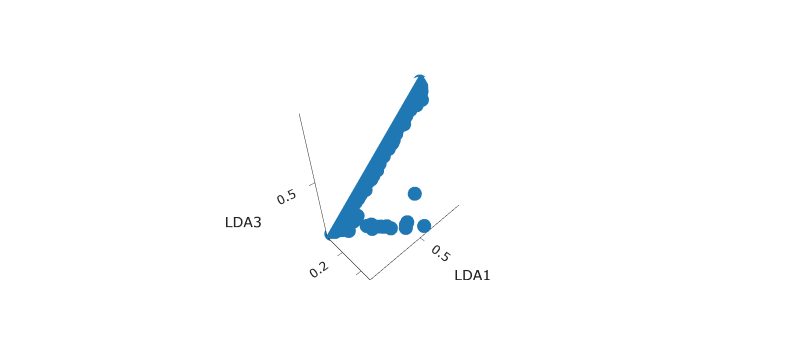

In [91]:
fig = px.scatter_3d(df_boardgames, 
                 x='LDA1', y='LDA2',z= 'LDA3', 
                 #color='wav_filename',
                 #symbol='wav_filename',
                 #labels='GameName',
                 #text='wav_filename',
                 hover_data=['GameId','GameName'],
                 template="simple_white"
                 #template="plotly_dark",
                 )
fig.show()

In [93]:
df_boardgames.head()

,GameId,GameName,Description,LDA1,LDA2,LDA3
0,148494,"1,2,3! Now you see me...",the animals on the farm are playing a game of ...,0.875053,0.060308,0.064639
1,316377,7 Wonders (Second Edition),7 wonders the board game with more awards than...,0.912681,0.039279,0.048040
2,155987,Abyss,the abyss power is once again vacant so the ti...,0.697477,0.049812,0.252711
3,21569,Adigma,adigma is a party game which involves simultan...,0.876832,0.058677,0.064491
4,31260,Agricola,description from boardgamenews in agricola you...,0.921185,0.038086,0.040729


## Similarity

### Cosine

In [10]:
similaritiesTfi = cosine_similarity(term_document_matrix)

In [11]:
for i in range(len(similaritiesTfi)):
        similaritiesTfi[i][i]=0

### Euclidean

In [13]:
distances=euclidean_distances(term_document_matrix,term_document_matrix)

In [14]:
for i in range(len(distances)):
    distances[i][i]=1000

## Save data

In [224]:
term_document_matrix.to_csv("TermMatrix.csv", index=False)
term_document_matrix_tfi.to_csv("TermMatrixTfi.csv", index= True)
df_boardgames.to_csv("df_boardgames.csv", index= False)

## Test

## Load data

In [7]:
term_document_matrix= pd.read_csv("TermMatrix.csv")
term_document_matrix_tfi= pd.read_csv("TermMatrixTfi.csv")
df_boardgames=pd.read_csv("df_boardgames.csv")

In [8]:
term_document_matrix_tfi.set_index('Unnamed: 0',inplace=True)

## Calculate distances

In [9]:
similaritiesTfi = cosine_similarity(term_document_matrix)
distances=euclidean_distances(term_document_matrix,term_document_matrix)

In [10]:
for i in range(len(distances)):
    distances[i][i]=1000
    similaritiesTfi[i][i]=0

# Example

In [11]:
df_boardgames.sample(5)

,GameId,GameName,Description,LDA1,LDA2,LDA3
198,267945,Mr. Face,a card with many lines written you will make y...,0.874352,0.060873,0.064775
604,172,For Sale,for sale is a quick fun game nominally about b...,0.892134,0.052908,0.054958
1007,165986,Royals,in royals players take on the roles of the gre...,0.898701,0.049021,0.052279
1826,174570,Legendary Encounters: A Predator Deck Building...,legendary encounters a predator deck building ...,0.085075,0.059742,0.855182
1151,199792,Everdell,within the charming valley of everdell beneath...,0.915029,0.040715,0.044256


In [20]:
initial=searchGame(df_boardgames, "Terraforming Mars")

In [21]:
ls_euclidian, ls_cosine = get_top_games(distances,similaritiesTfi,initial)

In [22]:
show_similar(df_boardgames,term_document_matrix_tfi,ls_cosine,ls_euclidian,1,initial)

El juego que te gusto es: Terraforming Mars 
GameId; 167791
Description: in the 2400s mankind begins to terraform the planet mars giant corporations sponsored by the world government on earth initiate huge projects to raise the temperature the oxygen level and the ocean coverage until the environment is habitable in terraforming mars you play one of those corporations and work together in the terraforming process but compete for getting victory points that are awarded not only for your contribution to the terraforming but also for advancing human infrastructure throughout the solar system and doing other commendable things the players acquire unique project cards from over two hundred different ones by buying them to their hand the projects cards can represent anything from introducing plant life or animals hurling asteroids at the surface building cities to mining the moons of jupiter and establishing greenhouse gas industries to heat up the atmosphere the cards can give you immediate

## Conclusiones

Que tanto se parecen los juegos es exclusivamente de la descripción del juego en la página de BGG, entonces estas descripciones llegan a ser muy inconsistentes, esto es hay algunas que traen mucha información con explicaciones temáticas y su forma de jugar y algunas solo cuentan con este último y son más escuetas.  
Por esta misma razón, no necesariamente el juego se parezca en términos de como se juega, el tiempo de juego u otras caracteristicas relevantes puesto que no se encuentra toda esa información en las descripciones.  

Aún así, logramos obtener una recomendación más basada en su temática la cual proporciona un inicio para darle la oportunidad a un juego y que el hecho de que no sean esencialmente igual los juegos no es necesariamente malo, porque al final puede tener dinámicas o porpuestas que le agraden a nuestro usuario.